In [1]:
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
from statistics import mode

(7016, 4961, 3)


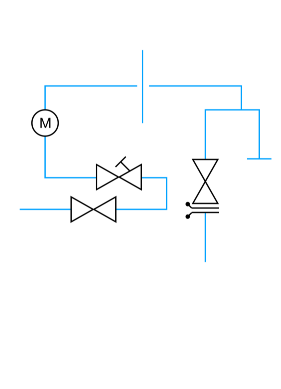

In [6]:
dpi_set = 600
# sch_grid = convert_from_path('./Single Valve PDF.pdf', dpi=dpi_set)[0]
# sch_grid = convert_from_path('./Double Valve Bend.pdf', dpi=dpi_set)[0]
# sch_grid = convert_from_path('./Triple Valve wBends.pdf', dpi=dpi_set)[0]
sch_grid = convert_from_path('./test_sch_1.pdf', dpi=dpi_set)[0]


sch_array = np.array(sch_grid)
            
print(sch_array.shape)

plt.imshow(sch_array)
plt.axis('off')
plt.show()

Start Direction: [0, 1]
 Start Position: (3810, 182)


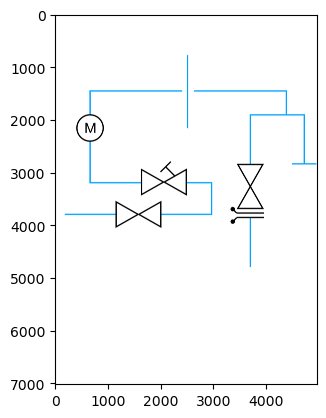

In [7]:
# Find the first point in the schematic to start from and the direction of travel


x_start = np.argmin(np.all(np.all(sch_array == 255, axis=0), axis=1))
y_start = np.argmin(np.all(sch_array[:,x_start] == 255, axis=1))

def find_direction(y, x, old_direction = [0,0]):

    paths = pd.DataFrame({
        'direction':[(-1,0), (1,0), (0,1), (0,-1)],
        'distance':[np.argmax(np.all(sch_array[:y + 1, x][::-1] == 255, axis = 1)),
                    np.argmax(np.all(sch_array[y:, x] == 255, axis = 1)),
                    np.argmax(np.all(sch_array[y, x:] == 255, axis = 1)),
                    np.argmax(np.all(sch_array[y, :x + 1][::-1] == 255, axis = 1))]
    })    
        
    avoid = [-x for x in old_direction]
        
    paths = paths[paths.direction != tuple(avoid)]
    
#     print(paths)
    
    if paths.distance.max() > round(dpi_set / 20):
    
        return list(paths.loc[paths.distance.idxmax(), 'direction'])
    
    else:
        print('Could not find direction.')
    
direction = find_direction(y_start, x_start)

print(f'Start Direction: {direction}')

print(f' Start Position: {y_start, x_start}')

plt.imshow(sch_array)
plt.show()

In [9]:
## Find line thickness and centre the tracer


thickness_slices = {
    (-1, 0): (slice(y_start - round(dpi_set/2), y_start), slice(x_start - round(dpi_set/4), x_start + round(dpi_set/4)),
              slice(None, None)),
    (1, 0): (slice(y_start, y_start + round(dpi_set/2)), slice(x_start - round(dpi_set/4), x_start + round(dpi_set/4)),
             slice(None, None)),
    (0, -1): (slice(y_start - round(dpi_set/4), y_start + round(dpi_set/4)), slice(x_start - round(dpi_set/2), x_start),
              slice(None, None)),
    (0, 1): (slice(y_start - round(dpi_set/4), y_start + round(dpi_set/4)), slice(x_start, x_start + round(dpi_set/2)),
             slice(None, None))
}

# Get the appropriate slices based on the direction

inspection_box = sch_array[thickness_slices.get(tuple(direction))]

# print(direction)
min_not_white = np.argmin(np.all(inspection_box == 255, axis=2), axis=abs(direction[0]))
max_not_white = len(inspection_box) - 1 - np.argmax(np.any(inspection_box[::-1] != 255, axis=2), axis=abs(direction[0]))

thicknesses = max_not_white - min_not_white
line_thickness = mode(thicknesses)
centre_line = round(mode(min_not_white + max_not_white)/2)

print(f'Line Thickness: {line_thickness}')

# Centre the tracer
y_start = y_start + (centre_line - round(dpi_set/4)) * abs(direction[1])
x_start = x_start + (centre_line - round(dpi_set/4)) * abs(direction[0])

sch_array[y_start, x_start] = [255,0,0]

print(f' Centred Start Position: {y_start, x_start}')


# plt.imshow(inspection_box)
# plt.axis('off')
# plt.show()

Line Thickness: 24
 Centred Start Position: (3798, 182)


Continuation Found.
Stored 'break_1' (ndarray)
Direction Change.
Direction Change.
Continuation Found.
Stored 'break_2' (ndarray)
Direction Change.
Continuation Found.
Stored 'break_3' (ndarray)
Direction Change.
Continuation Found.
Stored 'break_4' (ndarray)
Direction Change.
Direction Change.
Direction Change.
Continuation Found.
Stored 'break_5' (ndarray)
Could not find direction.
End of line.


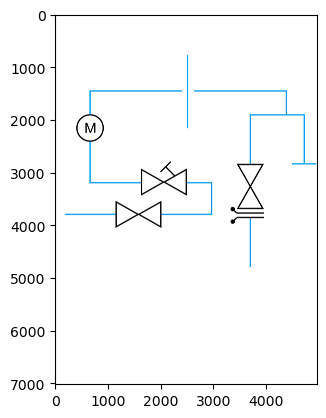

In [33]:
## Trace the lines and identify valves!

def classify(search_area, array_in, break_count = 0):
    
    ## This is where I'll classify the valves/breaks
    
    name = f'break_{break_count}'
    globals()[name] = array_in[search_area]
        
    %store {name}
    
#     plt.imshow(array_in[search_area])
#     plt.show()
    
    


def trace(y_coord, x_coord, direction, array_in):
    
    new_direction = direction
    array_out = np.copy(array_in)
    local_px = np.zeros((3,3,3))
    min_straight = 10 * line_thickness
    max_gap = 50 * line_thickness
    component_width = 36 * line_thickness
    break_count = 0
    
    while False in np.all(local_px == 255,axis=2):
        
        local_px = array_out[y_coord-1:y_coord+2, x_coord-1:x_coord+2, :]
        
        ## If there's a break, see if the line continues shortly after
        
        if np.all(local_px[new_direction[0]+1, new_direction[1]+1,:] == 255):
            
            break_y_start = y_coord - 6 * line_thickness * new_direction[0]
            break_x_start = x_coord - 6 * line_thickness * new_direction[1]
            
            direction_slices = {
                (-1, 0): (slice(None, y_coord + 1), x_coord, slice(None, None)),
                (1, 0): (slice(y_coord + 1, None), x_coord, slice(None, None)),
                (0, -1): (y_coord, slice(None, x_coord + 1), slice(None, None)),
                (0, 1): (y_coord, slice(x_coord + 1, None), slice(None, None))
            }
            
            dir_slice = array_out[direction_slices.get(tuple(new_direction))]
            
            
            
            line_present = [np.all(np.all(dir_slice[i : i + min_straight] == 255, axis=1) == False) 
                   for i in range(len(dir_slice) - min_straight + 1)]
            
            if line_present == []:                    
                line_loc = 0           
            else:
                line_loc = np.argmax(line_present[::(new_direction[0] + new_direction[1])])
                                                        # This ensures the line_location is always 
                                                        ## in relation to the current point, not just 
                                                        ### in relation to the slice
            
            ## If so, identify what the break is (potentially a valve)
                        
            if line_loc != 0 and line_loc <= max_gap:
                
                print('Continuation Found.')
                
                y_coord = y_coord + line_loc * new_direction[0]
                x_coord = x_coord + line_loc * new_direction[1]
            
                array_out[y_coord, x_coord] = [255,0,0]
                
                break_y_end = y_coord + 6 * line_thickness * new_direction[0]
                break_x_end = x_coord + 6 * line_thickness * new_direction[1]
                
                if break_y_start == break_y_end:
                    search_y = slice(y_coord - round(component_width/2), y_coord + round(component_width/2))
                    search_x = slice(min([break_x_start, break_x_end]), max([break_x_start, break_x_end]))
                
                elif break_x_start == break_x_end:
                    search_y = slice(min([break_y_start, break_y_end]), max([break_y_start, break_y_end]))
                    search_x = slice(x_coord - round(component_width/2), x_coord + round(component_width/2))

                else:
                    print('Error - Search area requested is not horizontal or vertical.')
                
                
                break_count += 1
                
                classify((search_y,search_x,slice(None,None)), array_in, break_count)

                    

            ## If not, see if its a change in direction
            
            elif find_direction(y_coord, x_coord, new_direction):
                
                print('Direction Change.')
                
                ## Centre the tracer
                y_coord = y_coord - round(line_thickness/2) * new_direction[0]
                x_coord = x_coord - round(line_thickness/2) * new_direction[1]
                
                new_direction = find_direction(y_coord, x_coord, new_direction)

            else:
                
                print('End of line.')
                break
                

        else:
            
            ## If there is no break, progress along the line in the direction of travel
            
            y_coord = y_coord + new_direction[0]
            x_coord = x_coord + new_direction[1]

            array_out[y_coord, x_coord] = [255,0,0]      
                
                
    plt.imshow(array_out)
#     plt.axis('off')
    plt.show()
    
    return array_out

out = trace(y_start, x_start, direction, sch_array)
